### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [3]:
aq_datasets = firealarm_processing.get_datasets()

In [4]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

GlobalAttrTitle GlobalAttrSource
0                                  MERRA-2 Global CDH         GES DISC
1                                 MERRA-2 Global PBLH         GES DISC
2                                 MERRA-2 Global TLML         GES DISC
3   MODIS Terra AOD 550 Dark Target Deep Blue Comb...         Giovanni
4   MODIS Terra Aerosol Optical Depth Land Ocean Mean         Giovanni
24         Sentinel-5P TROPOMI Methane CH4 California         GES DISC
25  Sentinel-5P TROPOMI Carbon Monoxide CO California         GES DISC
26    Sentinel-5P TROPOMI Tropospheric NO2 California         GES DISC
27         Sentinel-5P TROPOMI Total Ozone California         GES DISC
28  Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...         GES DISC

### In-situ data inventory

In [5]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

provider      project
0                      AirNow  air_quality
1                      AirNow        AQACF
2          GRIMM-Aethalometer        AQACF
3                   PurpleAir        AQACF
4                     QuantAQ     AQIC-Raw
5                     QuantAQ         AQIC
6                     QuantAQ  AQIC-Hourly
7           PurpleAir-GMU-Cal  air_quality
8  PurpleAir-GMU-Intermediate  air_quality
9    PurpleAir-GMU-Raw-Hourly  air_quality

In [6]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

index   platform               platform_short_name        lat  \
0         0  000010102                        St. John's  47.652800   
1         1  000010401                       Mount Pearl  47.505000   
2         2  000010501               Grand Falls Windsor  49.019400   
3         3  000010601                         Goose Bay  53.304700   
4         4  000010602  MacPherson Avenue - Corner Brook  48.952240   
...     ...        ...                               ...        ...   
3471   7059  TT1010003                         Inchelium  48.296960   
3472   7060  TT5420500              Santa Rosa Rancheria  36.233333   
3473   7062  TT9209004                             Miami  36.922222   
3474   7064  UB1010001                       Ulaanbaatar  47.928385   
3475   7066  UZB010001                          Tashkent  41.367200   

             lon          min_datetime          max_datetime  
0     -52.816700  2018-01-01T00:00:00Z  2022-02-28T00:00:00Z  
1     -52.794700  2018-01-01T00:00:00Z  2022-02-28T00:00:00Z  
2     -55.802800  2018-01-01T00:00:00Z  2021-03-31T00:00:00Z  
3     -60.364400  2018-01-02T00:00:00Z  2024-03-31T00:00:00Z  
4     -57.922070  2020-01-01T00:00:00Z  2022-02-28T00:00:00Z  
...          ...                   ...                   ...  
3471 -118.202420  2018-01-09T00:00:00Z  2019-05-31T00:00:00Z  
3472 -119.765083  2018-01-01T00:00:00Z  2023-08-24T00:00:00Z  
3473  -94.838890  2018-01-01T00:00:00Z  2024-03-31T00:00:00Z  
3474  106.929470  2018-01-01T00:00:00Z  2024-03-31T00:00:00Z  
3475   69.272500  2019-04-01T00:00:00Z  2024-03-31T00:00:00Z  

[3476 rows x 7 columns]

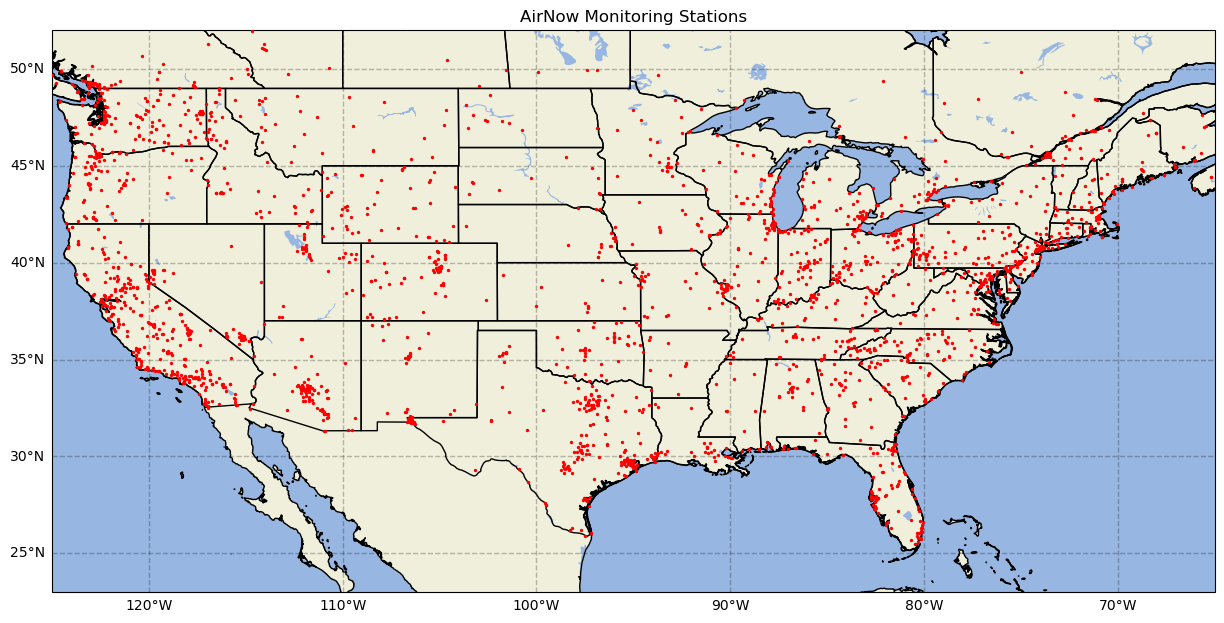

In [7]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# Los Angeles ports backlog Fall 2021
Beginning around October 2021, the Ports of Los Angeles and Long Beach started suffering serious backlogs of ships due a surge in e-commerence because of the COVID-19 pandemic. This resulted in many ships anchored in the ports and releasing high amounts of pollutants. 

Relevant Articles:
- https://earthobservatory.nasa.gov/images/149004/scientific-questions-arrive-in-ports
- https://earthobservatory.nasa.gov/images/148956/waiting-to-unload
- https://www.whitehouse.gov/briefing-room/statements-releases/2021/10/13/fact-sheet-biden-administration-efforts-to-address-bottlenecks-at-ports-of-los-angeles-and-long-beach-moving-goods-from-ship-to-shelf/ 

This usecase highlights the support for federated deployments. The PM2.5 analysis is seamlessly generated from a federated deployment hosted by GMU. 

### Area of interest

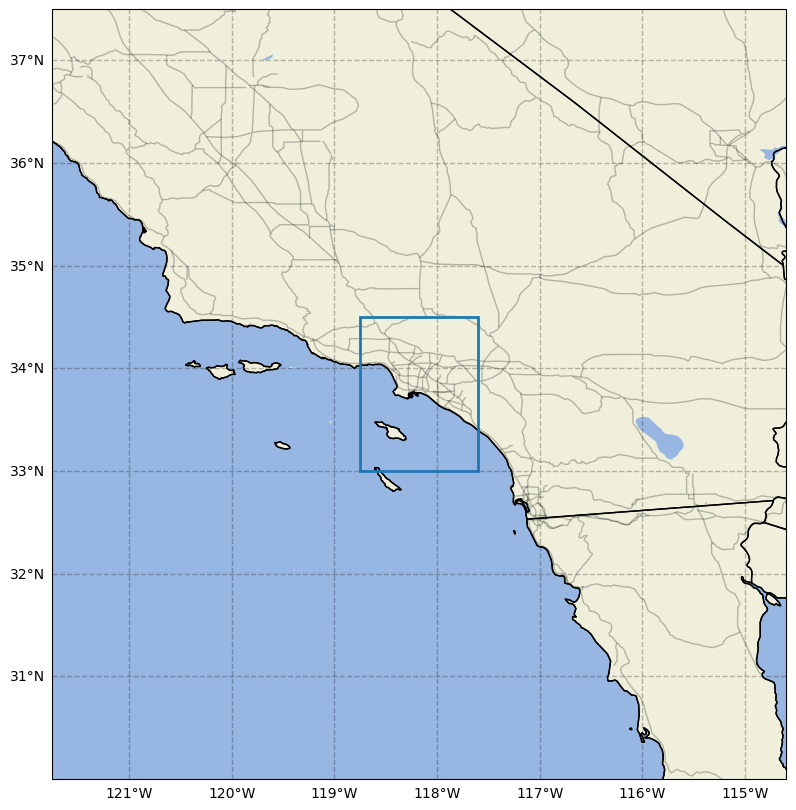

In [8]:
la_ports_bb = {
    'min_lon': -118.75,
    'max_lon': -117.6,
    'min_lat': 33,
    'max_lat': 34.5
}

la_ports_start_time = datetime(2021,10,1)
la_ports_end_time = datetime(2022,1,1)

plotting.map_box(la_ports_bb, padding=3)

In [9]:
la_ports_tropomi_no2 = firealarm_processing.spatial_timeseries('TROPOMI-0.1deg-CA-NO2', la_ports_bb, la_ports_start_time, la_ports_end_time)
la_ports_tropomi_so2 = firealarm_processing.spatial_timeseries('TROPOMI-0.1deg-CA-SO2', la_ports_bb, la_ports_start_time, la_ports_end_time)
la_ports_gmu_pm25 = firealarm_processing.spatial_timeseries('GMU-PM25', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-118.75&minLat=33&maxLon=-117.6&maxLat=34.5&startTime=2021-10-01T00%3A00%3A00Z&endTime=2022-01-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.94983779100221 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-118.75&minLat=33&maxLon=-117.6&maxLat=34.5&startTime=2021-10-01T00%3A00%3A00Z&endTime=2022-01-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 0.3433311249973485 seconds
https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GMU-PM25&minLon=-118.75&minLat=33&maxLon=-117.6&maxLat=34.5&startTime=2021-10-01T00%3A00%3A00Z&endTime=2022-01-01T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 15.328290166999068 seconds


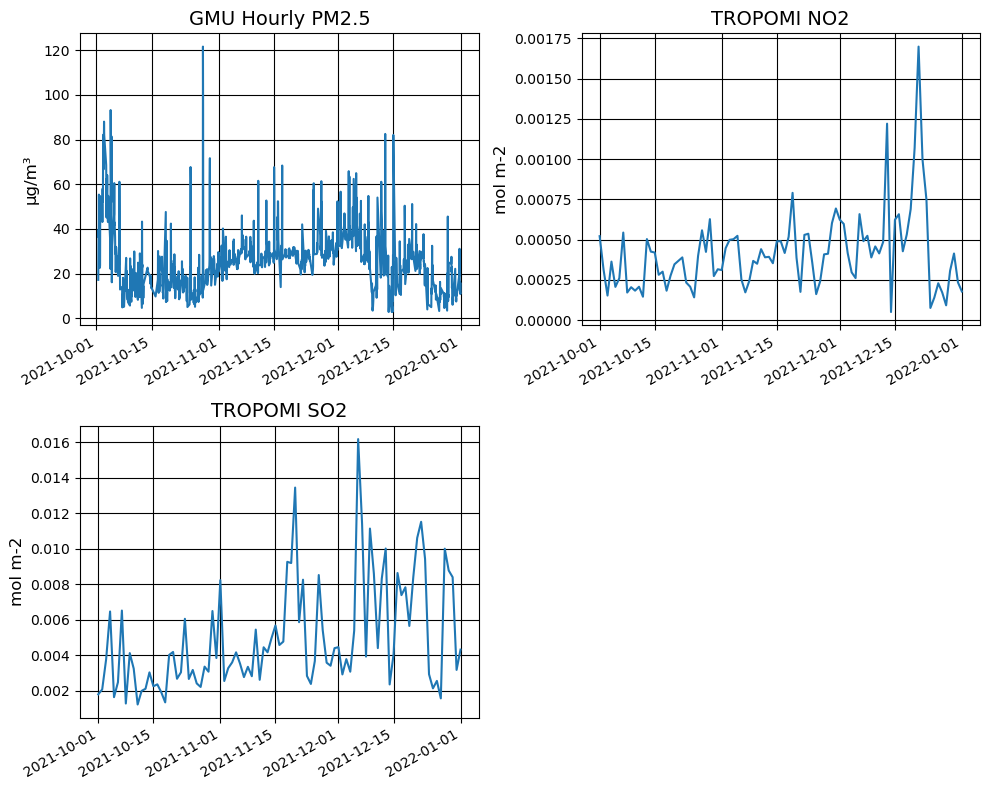

In [10]:
plotting.timeseries_multi_plot([(la_ports_gmu_pm25['maximum'], 'GMU Hourly PM2.5', 'µg/m³'), (la_ports_tropomi_no2['maximum'], 'TROPOMI NO2', 'mol m-2'), (la_ports_tropomi_so2['maximum'], 'TROPOMI SO2', 'mol m-2')])

In [11]:
la_ports_SO2_daily_diff_data = firealarm_processing.daily_diff('laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean', 'laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean_clim', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/dailydifferenceaverage_spark?dataset=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean&climatology=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean_clim&b=-118.75%2C33%2C-117.6%2C34.5&startTime=2021-10-01T00%3A00%3A00Z&endTime=2022-01-01T00%3A00%3A00Z

Waiting for response from FireAlarm... took 19.317330625002796 seconds


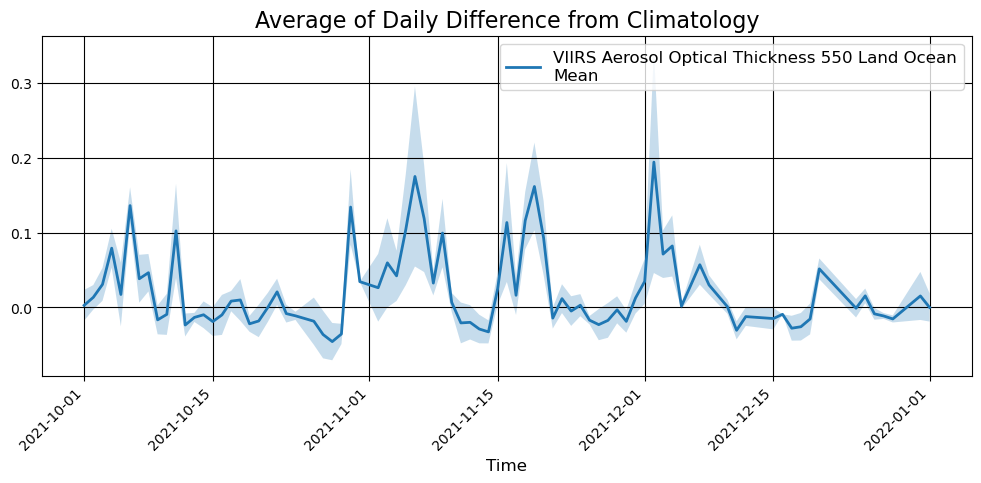

In [12]:
plotting.timeseries_bands_plot(la_ports_SO2_daily_diff_data, 'VIIRS Aerosol Optical Thickness 550 Land Ocean Mean', 'Time', '', 'Average of Daily Difference from Climatology')

In [13]:
# Connect to FireAlarm OnEarth WMS Service
wms = WebMapService('https://ideas-digitaltwin.jpl.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'TROPOMI_nitrogendioxide_tropospheric_column',
          'Reference_Features',
          'Reference_Labels']
font = ImageFont.truetype('Roboto-Bold.ttf', size=18)
color = 'rgb(255,255,255)'
frames = []

dates = pd.date_range(la_ports_start_time,la_ports_end_time-timedelta(days=1),freq='d')

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(-122, 32.5, -114, 38), # Bounds
                     size=(500, 500),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 12)
    draw.text((x, y), f'TROPOMI NO2 Total Column  - {datatime}', fill=color, font=font)
    frames.append(image)

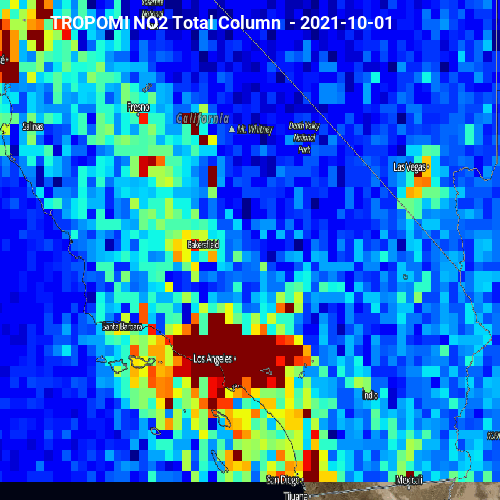

In [14]:
frames[0].save('TROPOMI_nitrogendioxide_tropospheric_column.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=500,
               loop=0)

Image('TROPOMI_nitrogendioxide_tropospheric_column.gif')